In [1]:
project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

In [2]:
from IPDL import MatrixEstimator
from IPDL import TensorKernel
from IPDL import MatrixBasedRenyisEntropy as renyis
from IPDL.optim import AligmentOptimizer
from IPDL import ClassificationInformationPlane

In [3]:
# import numpy as np
# from IPDL.utils import moving_average as mva
# from IPDL import InformationPlane_ as InformationPlane
# from IPDL.InformationPlane import TensorKernel
# from models.MLP import MLP2
# from IPDL.optim import MatrixOptimizer

In [3]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor
from torch.nn.functional import one_hot
from tqdm import tqdm

from models.MLP import MLP2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLP2().to(device)
matrix_optimizer = AligmentOptimizer(net, beta=0.1, n_sigmas=150)
# ip = InformationPlane.ClassificationInformationPlane(net, use_softmax=True)
ip = ClassificationInformationPlane(net, use_softmax=True)

In [4]:
transformToTensor = Compose([ ToTensor() ])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [59850 , 150])
dataloader = DataLoader(train_set, batch_size=120, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=150, shuffle=False, num_workers=0)

val_inputs, val_labels = next(iter(dataloader_2))
val_inputs = val_inputs.flatten(1).to(device)
val_labels = one_hot(val_labels, num_classes=10).float().to(device)

Kx = TensorKernel.RBF(val_inputs, sigma=8).to(device)
Ky = TensorKernel.RBF(val_labels, sigma=0.1).to(device)
Ax = Kx/val_inputs.size(0)
Ay = Ky/val_labels.size(0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs)
        
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.flatten(1).to(device)
        labels = labels.to(device)

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:
            loss_record.append(running_loss / 50)
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs)
            matrix_optimizer.step(Ky)
            ip.computeMutualInformation(Ax.cpu(), Ay.cpu())

        if i > 500:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(100)

        i += 1
 
print('Finished Training')

100%|██████████| 499/499 [04:06<00:00,  2.02it/s]Finished Training



In [7]:
from utils import moving_average, showMutualInformation
from matplotlib import pyplot as plt
import numpy as np

Ixts, Itys = ip.getMutualInformation(moving_average_n=10)

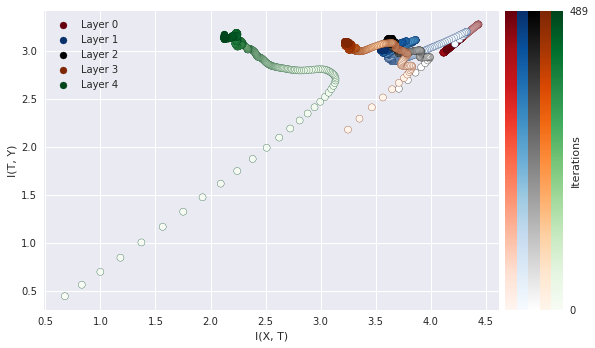

In [8]:
colors=['Reds', 'Blues', 'binary', 'Oranges', 'Greens']
with plt.style.context('seaborn'):
    fig = plt.figure(constrained_layout=False)
    gs1 = fig.add_gridspec(nrows=1, ncols=1, left=0.05, right=0.84, wspace=0.05)
    gs2 = fig.add_gridspec(nrows=1, ncols=len(Ixts), left=0.85, right=0.95, wspace=0)
    f8_ax1 = fig.add_subplot(gs1[:, :])
    f8_ax1.set_xlabel("I(X, T)")
    f8_ax1.set_ylabel("I(T, Y)")

    for idx, Ixt in enumerate(Ixts):
        Ity = Itys[idx]
        cmap = plt.cm.get_cmap(colors[idx])
        # Ixt, Ity = ip.getMutualInformation()
        # Ixt = moving_average(Ixt, n=10)
        # Ity = moving_average(Ity, n=10)
        iterations = np.arange(len(Ixt))
        color = np.array([cmap(iterations[-1])])
        sc = f8_ax1.scatter(Ixt, Ity, c=iterations, vmin=0, vmax=iterations.max(), cmap=cmap, edgecolor=color)
        f8_ax1.scatter([], [], c=color, label="Layer {}".format(idx))

        f8_ax2 = fig.add_subplot(gs2[0, idx])
        cb = fig.colorbar(sc, cax=f8_ax2, pad=0)
        cb.set_ticks([])

    f8_ax1.legend()
    cb.set_ticks([0, iterations.max()])
    cb.set_label("Iterations", labelpad=-18)

    plt.show()

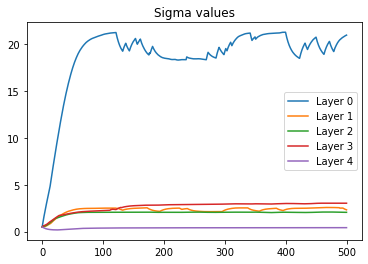

In [9]:
from matplotlib import pyplot as plt
sigma_per_layers = matrix_optimizer.sigma_prev

for idx, sigmas in enumerate(sigma_per_layers):
    plt.plot(sigmas, label="Layer {}".format(idx))

plt.title("Sigma values")
plt.legend()
plt.show()